## Scraping borough councils

### Scraping experiments

In [25]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, parse_qs
import time
import json
import os
import re

# Load the CSV file
df = pd.read_csv("/Users/lgfolder/Downloads/rtw.csv")

# Set for visited URLs to prevent duplicates
visited = set()

# Path to results file
results_path = "/Users/lgfolder/Downloads/pdf_results_rtw.json"
if os.path.exists(results_path):
    with open(results_path, "r") as f:
        results_log = json.load(f)
else:
    results_log = []

# Helper: Check if a URL points to a PDF
def is_pdf(url):
    return url.lower().endswith(".pdf")

# Helper: Allow only ieListDocuments URLs with CId and MId (order-insensitive)
def is_allowed_ieListDocuments_url(url):
    if not isinstance(url, str):
        return False
    parsed = urlparse(url)
    if "ieListDocuments.aspx" not in parsed.path:
        return False
    query = parse_qs(parsed.query)
    return "CId" in query and "MId" in query

# Helper: Check if it's a valid starting page (meeting list)
def is_valid_start_url(url):
    return isinstance(url, str) and url.startswith("http") and "ieListMeetings.aspx" in url

# Crawl PDFs from a specific meeting document page
def crawl_ieListDocuments_page(url, topic, source_url, depth=0, max_depth=2):
    pdf_links = set()
    if depth > max_depth or url in visited:
        return pdf_links

    if not is_allowed_ieListDocuments_url(url):
        return pdf_links

    visited.add(url)
    print(f"Crawling: {url} (depth={depth})")

    try:
        resp = requests.get(url, timeout=10)
        if resp.status_code != 200:
            return pdf_links
    except Exception as e:
        print(f"Failed to fetch {url}: {e}")
        return pdf_links

    soup = BeautifulSoup(resp.text, "html.parser")

    # Try to extract committee, date, and time from a heading
    committee = date = time_ = None
    heading_text = soup.find(string=re.compile(r" - .*\d{1,2}.*\d{4}"))
    if heading_text:
        match = re.match(r"(?P<committee>.+?) - .*?(?P<date>\d{1,2}(?:st|nd|rd|th)?\s+\w+,\s+\d{4})\s+(?P<time>\d{1,2}\.\d{2}\s*[ap]m)", heading_text.strip(), re.IGNORECASE)
        if match:
            committee = match.group("committee").strip()
            date = match.group("date").strip()
            time_ = match.group("time").strip()

    for a_tag in reversed(soup.find_all("a", href=True)):
        link = urljoin(url, a_tag['href'])
        if is_pdf(link):
            if link not in pdf_links:
                pdf_links.add(link)
                # Save immediately with metadata
                results_log.append({
                    "topic": topic,
                    "source_url": source_url,
                    "page_url": url,
                    "pdf_url": link,
                    "committee": committee,
                    "date": date,
                    "time": time_
                })
                with open(results_path, "w") as f:
                    json.dump(results_log, f, indent=2)
        time.sleep(0.25)

    return pdf_links

# Top-level crawler: start from meeting list, extract child meeting document pages
def crawl_from_meeting_list(start_url, topic):
    meeting_pdf_links = set()

    print(f"Scanning meeting list: {start_url}")
    try:
        resp = requests.get(start_url, timeout=10)
        if resp.status_code != 200:
            return meeting_pdf_links
    except Exception as e:
        print(f"Failed to fetch meeting list page {start_url}: {e}")
        return meeting_pdf_links

    soup = BeautifulSoup(resp.text, "html.parser")
    for a_tag in soup.find_all("a", href=True):
        link = urljoin(start_url, a_tag['href'])
        if is_allowed_ieListDocuments_url(link):
            meeting_pdf_links |= crawl_ieListDocuments_page(link, topic, start_url)
            time.sleep(0.25)

    return meeting_pdf_links

# Run crawler for each topic
pdf_map = {}
for _, row in df.iterrows():
    topic = row.get('topic')
    start_url = row.get('mother_url')

    if not is_valid_start_url(start_url):
        print(f"Skipping (not allowed): {start_url}")
        continue

    visited.clear()
    pdf_links = crawl_from_meeting_list(start_url, topic)
    pdf_map[topic] = list(pdf_links)
    print(f"Saved {len(pdf_links)} PDFs for topic: {topic}\n")

# The pdf_map now holds topic -> [list of PDF URLs]


Scanning meeting list: https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5735&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=6006&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5998&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5732&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5916&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5917&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5731&Ver=4 (depth=0)
Crawling: https://democracy.tunbridgewells.gov.uk/ieListDocuments.asp

In [26]:
import pandas as pd
import json

# Load the JSON file
with open(results_path, "r") as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Drop duplicate PDF URLs, keeping the first occurrence
df_deduped = df.drop_duplicates(subset=["pdf_url"])
pd.set_option('display.max_colwidth', None)  # Show full column content
# Display the deduplicated DataFrame
df_deduped  # or just df_deduped to see all

,topic,source_url,page_url,pdf_url,committee,date,time
0,full_council,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s76874/17. Date of Next Meeting.pdf,Full Council,"23rd April, 2025",6.30 pm
1,full_council,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s76873/16. Common Seal of the Council.pdf,Full Council,"23rd April, 2025",6.30 pm
2,full_council,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s76872/15. Urgent Business.pdf,Full Council,"23rd April, 2025",6.30 pm
3,full_council,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s76856/Appendix B - Appointments to Committees.pdf,Full Council,"23rd April, 2025",6.30 pm
4,full_council,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=134,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5734&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s76855/Appendix A Political balance and allocation of Committee seats.pdf,Full Council,"23rd April, 2025",6.30 pm
...,...,...,...,...,...,...,...
668,cabinet,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=118,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5640&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s70614/Minutes 07122023 Cabinet.pdf,"Additional, Cabinet","25th January, 2024",6.30 pm
669,cabinet,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=118,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5640&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s70613/4 Notification of Persons Registered to Speak.pdf,"Additional, Cabinet","25th January, 2024",6.30 pm
670,cabinet,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=118,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5640&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s70612/3 Declarations of Interest.pdf,"Additional, Cabinet","25th January, 2024",6.30 pm
671,cabinet,https://democracy.tunbridgewells.gov.uk/ieListMeetings.aspx?CommitteeId=118,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5640&Ver=4,https://democracy.tunbridgewells.gov.uk/documents/s70611/2 Apologies for Absence.pdf,"Additional, Cabinet","25th January, 2024",6.30 pm


In [15]:

# Get unique page URLs
unique_pages = df["page_url"].drop_duplicates()

# Display the count and the URLs
#print(f"Total unique page URLs: {len(unique_pages)}")
unique_pages.reset_index(drop=True)  # Nicely indexed for viewing
unique_pages

0        https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5402&Ver=4
5                     https://democracy.tunbridgewells.gov.uk/mgAi.aspx?ID=38964#mgDocuments
20     https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MID=5402#AI38964
48     https://democracy.tunbridgewells.gov.uk/mgParishCouncilDetails.aspx?LS=17&SLS=4&bcr=1
49                                https://democracy.tunbridgewells.gov.uk/mgAi.aspx?ID=38964
64                                https://democracy.tunbridgewells.gov.uk/mgAi.aspx?ID=38868
70     https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MID=5402#AI38868
98                 https://democracy.tunbridgewells.gov.uk/ieDecisionDetails.aspx?AIId=38762
99             https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MID=5411
118                               https://democracy.tunbridgewells.gov.uk/mgAi.aspx?ID=38866
120    https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CI

#### Downloading the texts and metadata from the pdfs without saving them

In [41]:
import requests
import pdfplumber
from io import BytesIO

url = "https://democracy.tunbridgewells.gov.uk/documents/s70214/15.%20Date%20of%20Next%20Meeting.pdf"
#url = "https://democracy.tunbridgewells.gov.uk/documents/s76856/Appendix B - Appointments to Committees.pdf"
#url = "https://democracy.tunbridgewells.gov.uk/documents/s76855/Appendix A Political balance and allocation of Committee seats.pdf"
#url = "https://democracy.tunbridgewells.gov.uk/documents/s76866/10 Motion on Notice from Cllr Mobbs.pdf"

def extract_text_from_pdf_url(url):
    try:
        response = requests.get(url, stream=True, timeout=15)
        response.raise_for_status()
        with pdfplumber.open(BytesIO(response.content)) as pdf:
            text = ''
            for page in pdf.pages:
                text += page.extract_text() or ''
        return text.strip()
    except Exception as e:
        return f"Failed: {e}"

# Run it
extract_text_from_pdf_url(url)

'Date of Next Meeting\nFor Full Council on Wednesday 13 December 2023\nProcedural Item\nTo note that the next scheduled meeting is Wednesday 28 February 2024.\nPage Tunbridge Wells Borough Council\n1 of 1 Date of Next Meeting'

### Downloading pdf metadata from one url link

In [42]:
import requests
from PyPDF2 import PdfReader
from io import BytesIO
import pandas as pd


def extract_all_pdf_metadata(url):
    try:
        response = requests.get(url, stream=True, timeout=15)
        response.raise_for_status()
        content = response.content

        reader = PdfReader(BytesIO(content))
        raw_meta = reader.metadata or {}

        # Convert keys to plain strings (e.g., "/Author" → "Author")
        meta = {k.strip('/'): v for k, v in raw_meta.items()}

        # Add general info
        meta["Pages"] = len(reader.pages)
        meta["Encrypted"] = reader.is_encrypted
        meta["FileSizeBytes"] = len(content)
        meta["PDFHeader"] = content[:8].decode("utf-8", errors="ignore").strip()

        # Page size (if available)
        try:
            box = reader.pages[0].mediabox
            meta["PageWidth"] = float(box.width)
            meta["PageHeight"] = float(box.height)
        except Exception:
            pass

        return meta
    except Exception as e:
        return {"error": str(e)}

# Example usage:
metadata = extract_all_pdf_metadata(url)
df_meta = pd.DataFrame([metadata])
df_meta

,Title,Author,Creator,CreationDate,ModDate,Producer,Pages,Encrypted,FileSizeBytes,PDFHeader,PageWidth,PageHeight
0,Date of Next Meeting,Jane Clarke,Microsoft® Word for Microsoft 365,D:20231205130031+00'00',D:20231205130031+00'00',Microsoft® Word for Microsoft 365,1,False,28509,%PDF-1.7,595.32,841.92


### Downloading metadata from all urls from the scraping results json

In [ ]:
import json
import requests
from PyPDF2 import PdfReader
from io import BytesIO
import pandas as pd
from tqdm import tqdm  # progress bar

# Load results from your scraper
with open("/Users/lgfolder/Downloads/pdf_results.json", "r") as f:
    data = json.load(f)

# Extract unique PDF URLs
pdf_urls = list({entry["pdf_url"] for entry in data if entry.get("pdf_url", "").endswith(".pdf")})

def extract_all_pdf_metadata(url):
    try:
        response = requests.get(url, stream=True, timeout=15)
        response.raise_for_status()
        content = response.content

        reader = PdfReader(BytesIO(content))
        raw_meta = reader.metadata or {}
        meta = {k.strip('/'): v for k, v in raw_meta.items()}

        # General info
        meta["Pages"] = len(reader.pages)
        meta["Encrypted"] = reader.is_encrypted
        meta["FileSizeBytes"] = len(content)
        meta["PDFHeader"] = content[:8].decode("utf-8", errors="ignore").strip()
        meta["SourceURL"] = url

        # Page dimensions
        try:
            box = reader.pages[0].mediabox
            meta["PageWidth"] = float(box.width)
            meta["PageHeight"] = float(box.height)
        except Exception:
            pass

        return meta
    except Exception as e:
        return {"SourceURL": url, "error": str(e)}

# Run metadata extraction for each PDF
metadata_list = [extract_all_pdf_metadata(url) for url in tqdm(pdf_urls)]

# Display as DataFrame
df_meta = pd.DataFrame(metadata_list)
df_meta

100%|██████████| 109/109 [00:57<00:00,  1.91it/s]


,Title,Author,Creator,CreationDate,ModDate,Producer,Pages,Encrypted,FileSizeBytes,PDFHeader,SourceURL,PageWidth,PageHeight,Keywords,AAPL:Keywords,Subject,Trapped
0,Questions from members of the Council,Mark O'Callaghan,Microsoft® Word for Microsoft 365,D:20231208094738+00'00',D:20231208094738+00'00',Microsoft® Word for Microsoft 365,1,False,124136,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s70269/Question ONLY from members of the Council 13 December.pdf,595.32,841.92,NaN,NaN,NaN,NaN
1,NaN,Helen Ward,Microsoft® Word for Microsoft 365,D:20231205115320+00'00',D:20231205115320+00'00',Microsoft® Word for Microsoft 365,4,False,116783,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s70184/Appendix B.pdf,595.32,841.92,NaN,NaN,NaN,NaN
2,Notice of Use of Urgency Procedures,Jane Clarke,Microsoft® Word for Microsoft 365,D:20231130151128+00'00',D:20231130151128+00'00',Microsoft® Word for Microsoft 365,1,False,76717,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s70156/9. Notice of Use of Urgency Procedures.pdf,595.32,841.92,NaN,NaN,NaN,NaN
3,Proposed Changes to the Council’s Constitution,Jane Clarke,Microsoft® Word for Microsoft 365,D:20240322093819+00'00',D:20240322093819+00'00',Microsoft® Word for Microsoft 365,6,False,185202,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71821/Report for Changes to Consitution - APNA 2022 and PSH - FC.pdf,595.32,841.92,NaN,NaN,NaN,NaN
4,NaN,Helen Ward,Microsoft® Word for Microsoft 365,D:20240322093824+00'00',D:20240322093824+00'00',Microsoft® Word for Microsoft 365,5,False,161851,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71822/Appendix A.pdf,595.32,841.92,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Declarations of Interest,Jane Clarke,Microsoft® Word for Microsoft 365,D:20240221102459+00'00',D:20240221102459+00'00',Microsoft® Word for Microsoft 365,1,False,67657,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71238/2. Declarations of Interest.pdf,595.32,841.92,NaN,NaN,NaN,NaN
105,Notice of Use of Urgency Procedures,Jane Clarke,Microsoft® Word for Microsoft 365,D:20240220105745+00'00',D:20240220105745+00'00',Microsoft® Word for Microsoft 365,1,False,76176,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71194/7. Notice of Use of Urgency Procedures.pdf,595.32,841.92,NaN,NaN,NaN,NaN
106,NaN,Russell Heppleston,Microsoft® Word for Microsoft 365,D:20240209121224+00'00',D:20240209121224+00'00',Microsoft® Word for Microsoft 365,9,False,283316,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71016/Appendix A Audit Governance Committee Annual Report 2022-23.pdf,595.32,841.92,NaN,NaN,NaN,NaN
107,Strategic Risk Register,Jane Clarke,Microsoft® Word for Microsoft 365,D:20240220101641+00'00',D:20240220101641+00'00',Microsoft® Word for Microsoft 365,5,False,127528,%PDF-1.7,https://democracy.tunbridgewells.gov.uk/documents/s71189/Appointment of TWBC IP 2024.pdf,595.32,841.92,NaN,NaN,NaN,NaN


### Scrape the full content of PDF files from links in JSONs

In [57]:
import json, time, hashlib, requests, os
from PyPDF2 import PdfReader
from io import BytesIO
import jsonlines
from tqdm import tqdm
import re
from datetime import datetime

# INPUT: Load results JSON
with open("/Users/lgfolder/Downloads/pdf_results.json", "r") as f:
    scraped_records = json.load(f)

# OUTPUT paths
jsonl_path = "/Users/lgfolder/Downloads/raw_scraped_metadata_rtw_test.jsonl"
id_register_path = "/Users/lgfolder/Downloads/document_ids_rtw_test.json"

# Convert to lookup by URL
scraped_by_url = {r["pdf_url"]: r for r in scraped_records if "pdf_url" in r}

# Load or initialize ID register
if os.path.exists(id_register_path):
    with open(id_register_path, "r") as f:
        doc_id_register = json.load(f)
else:
    doc_id_register = {}

# Track existing IDs to avoid duplication
existing_ids = set(doc["id"] for doc in doc_id_register.values())

# Utility: Generate short hash-based ID
def compute_doc_id(content):
    short_hash = hashlib.sha256(content).hexdigest()[:8]
    return f"doc_{short_hash}"

# Utility: Clean string to avoid json serialization issues
def clean_meta(meta):
    return {k.strip("/"): str(v) if v is not None else None for k, v in meta.items()}

# Utility: Extract meeting date from title or subject
def extract_meeting_date(text):
    match = re.search(r"(\d{1,2})[\-/](\d{1,2})[\-/](\d{2,4})", text)
    if match:
        d, m, y = match.groups()
        if len(y) == 2:
            y = '20' + y  # assume 21st century
        try:
            return datetime(int(y), int(m), int(d)).strftime("%Y-%m-%d")
        except:
            return None
    return None

# Classify document type from title or URL
def classify_doc_type(title, url):
    title = (title or "").lower()
    url = url.lower()
    if "agenda" in title or "agenda" in url:
        return "Agenda"
    elif "minute" in title or "minute" in url:
        return "Minutes"
    elif "report" in title or "report" in url:
        return "Report"
    return "Unknown"

# Main extractor
def extract_pdf_metadata(url):
    try:
        response = requests.get(url, stream=True, timeout=20)
        response.raise_for_status()
        content = response.content

        doc_id = compute_doc_id(content)
        if doc_id in existing_ids:
            return None, None  # already processed

        reader = PdfReader(BytesIO(content))
        raw_meta = clean_meta(reader.metadata or {})
        text = ''.join((p.extract_text() or '') for p in reader.pages)

        # Base record
        record = {
            "document_id": doc_id,
            "source_url": url,
            "title": raw_meta.get("Title"),
            "author": raw_meta.get("Author"),
            "creator": raw_meta.get("Creator"),
            "producer": raw_meta.get("Producer"),
            "created": raw_meta.get("CreationDate"),
            "modified": raw_meta.get("ModDate"),
            "subject": raw_meta.get("Subject"),
            "keywords": raw_meta.get("Keywords"),
            "pages": len(reader.pages),
            "filesize_bytes": len(content),
            "text": text.strip(),
            "word_count": len(text.split()),
            "char_count": len(text),
            "avg_words_per_page": round(len(text.split()) / max(1, len(reader.pages)), 2),
            "error": None  # placeholder for error tracking
        }

        # Scraping step 1 integration
        scraped = scraped_by_url.get(url, {})
        record.update({
            "page_url": scraped.get("page_url"),
            "topic": scraped.get("topic"),
            "committee": scraped.get("committee"),
            "meeting_date": scraped.get("date"),
            "meeting_time": scraped.get("time")
        })

        # Fallback date extraction
        if not record["meeting_date"]:
            record["meeting_date"] = extract_meeting_date(record.get("title", "") + record.get("subject", ""))

        # Document classification
        record["document_type"] = classify_doc_type(record.get("title"), url)

        return record, doc_id

    except Exception as e:
        return {"source_url": url, "error": str(e)}, None

# Collect and process all unique PDF URLs
pdf_urls = list({entry["pdf_url"] for entry in scraped_records if entry.get("pdf_url", "").endswith(".pdf")})

with jsonlines.open(jsonl_path, mode="a") as writer:
    for url in tqdm(pdf_urls):
        record, doc_id = extract_pdf_metadata(url)
        if record and doc_id:
            writer.write(record)
            doc_id_register[url] = {"id": doc_id}
        time.sleep(2.0)

# Save document ID register
with open(id_register_path, "w") as f:
    json.dump(doc_id_register, f, indent=2)


100%|██████████| 673/673 [30:31<00:00,  2.72s/it] 


In [59]:
import pandas as pd
import jsonlines

# Path to your metadata file

# Load all lines
with jsonlines.open(jsonl_path) as reader:
    records = list(reader)

# Remove the 'text' field from each record
for r in records:
    r.pop("text", None)

# Create and display DataFrame
df = pd.DataFrame(records)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673 entries, 0 to 672
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   document_id         673 non-null    object 
 1   source_url          673 non-null    object 
 2   title               474 non-null    object 
 3   author              659 non-null    object 
 4   creator             657 non-null    object 
 5   producer            673 non-null    object 
 6   created             673 non-null    object 
 7   modified            671 non-null    object 
 8   subject             25 non-null     object 
 9   keywords            48 non-null     object 
 10  pages               673 non-null    int64  
 11  filesize_bytes      673 non-null    int64  
 12  word_count          673 non-null    int64  
 13  char_count          673 non-null    int64  
 14  avg_words_per_page  673 non-null    float64
 15  error               0 non-null      object 
 16  page_url

In [60]:
df.sample(5)

,document_id,source_url,title,author,creator,producer,created,modified,subject,keywords,...,word_count,char_count,avg_words_per_page,error,page_url,topic,committee,meeting_date,meeting_time,document_type
375,doc_f8ab3b6d,https://democracy.tunbridgewells.gov.uk/documents/s71187/Appendix C FC Council Tax Sample bills 2024_25.pdf,None,administrator,Microsoft® Excel® for Microsoft 365,Microsoft® Excel® for Microsoft 365,D:20240220100956+00'00',D:20240220100956+00'00',None,None,...,961,6737,480.5,None,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5403&Ver=4,full_council,Full Council,"28th February, 2024",6.30 pm,Unknown
297,doc_4b35148f,https://democracy.tunbridgewells.gov.uk/documents/s70214/15. Date of Next Meeting.pdf,Date of Next Meeting,Jane Clarke,Microsoft® Word for Microsoft 365,Microsoft® Word for Microsoft 365,D:20231205130031+00'00',D:20231205130031+00'00',None,None,...,39,241,39.0,None,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5402&Ver=4,full_council,Full Council,"13th December, 2023",6.30 pm,Unknown
564,doc_5f16c2e6,https://democracy.tunbridgewells.gov.uk/documents/s71579/1.1 Q3 PI Report 7 Feb 24.pdf,Performance Summary Q3 2023/24 (Oct-Dec 2023),Jane Clarke,Microsoft® Word for Microsoft 365,Microsoft® Word for Microsoft 365,D:20240313121303+00'00',D:20240313121303+00'00',None,None,...,2052,13448,256.5,None,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5415&Ver=4,cabinet,Cabinet,"21st March, 2024",6.30 pm,Report
336,doc_9ae8a90a,https://democracy.tunbridgewells.gov.uk/documents/s71600/Quarter 3 Revenue Management 202324.pdf,Revenue Management: Quarter 3 (to 31 December 2023),Jane Clarke,Microsoft® Word for Microsoft 365,Microsoft® Word for Microsoft 365,D:20240313121419+00'00',D:20240313121419+00'00',None,None,...,3406,21261,340.6,None,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=118&MId=5415&Ver=4,cabinet,Cabinet,"21st March, 2024",6.30 pm,Unknown
80,doc_907d2958,https://democracy.tunbridgewells.gov.uk/documents/s76147/Appendix E Pay policy 2025 to 2026 pre review.pdf,None,William Benson,Microsoft® Word for Microsoft 365,Microsoft® Word for Microsoft 365,D:20250213112948+00'00',D:20250213112948+00'00',None,None,...,1583,9930,316.6,None,https://democracy.tunbridgewells.gov.uk/ieListDocuments.aspx?CId=134&MId=5732&Ver=4,full_council,"Full Council Ordinary Meeting, Full Council","26th February, 2025",6.45 pm,Unknown


### EDA of metadata

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jsonlines
import re
from datetime import datetime

# Load enriched metadata
#jsonl_path = "/Users/lgfolder/Downloads/raw_scraped_metadata_rtw_test_enriched.jsonl"
jsonl_path = '../data/meetings/meetings_metadata.jsonl'
with jsonlines.open(jsonl_path) as reader:
    records = list(reader)

# Drop text field for performance
for r in records:
    r.pop("text", None)

df = pd.DataFrame(records)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1583 entries, 0 to 1582
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   web_meeting_code  1583 non-null   object
 1   meeting_title     1571 non-null   object
 2   meeting_status    1571 non-null   object
 3   committee_name    1570 non-null   object
 4   meeting_date      1570 non-null   object
 5   meeting_time      1570 non-null   object
 6   agenda_items      1571 non-null   object
 7   meeting_id        1583 non-null   object
 8   scrape_timestamp  1583 non-null   object
 9   error             12 non-null     object
dtypes: object(10)
memory usage: 123.8+ KB


In [ ]:

# === Fix PDF metadata date format (e.g., D:20240313121419+00'00') ===
def clean_pdf_date(date_str):
    if not isinstance(date_str, str) or not date_str.startswith("D:"):
        return None
    try:
        match = re.match(r"D:(\d{4})(\d{2})(\d{2})(\d{2})(\d{2})(\d{2})", date_str)
        if match:
            y, m, d, h, mi, s = map(int, match.groups())
            return datetime(y, m, d, h, mi, s)
    except Exception:
        return None
    return None

df["created_parsed"] = df["created"].apply(clean_pdf_date)
df["year_month"] = df["created_parsed"].dt.to_period("M")

# === Parse meeting_date to YYYY-MM-DD ===
df["meeting_date_parsed"] = pd.to_datetime(df["meeting_date"], errors="coerce", dayfirst=True)

# === Additional prep ===
df["author_clean"] = df["author"].fillna("Unknown")
df["text_length"] = df["char_count"]  # Already computed earlier
df["pages"] = pd.to_numeric(df["pages"], errors="coerce")

# === Visualizations ===

# 1. Creation date distribution
if df["year_month"].notna().any():
    plt.figure(figsize=(10, 4))
    df["year_month"].value_counts().sort_index().plot(kind="bar")
    plt.title("PDFs by Creation Date (Year-Month)")
    plt.xlabel("Creation Date")
    plt.ylabel("Document Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 2. Top 10 authors
plt.figure(figsize=(8, 4))
df["author_clean"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Authors")
plt.xlabel("Author")
plt.tight_layout()
plt.show()

# 3. Text length distribution
plt.figure(figsize=(8, 4))
df["text_length"].plot(kind="hist", bins=30)
plt.title("Distribution of Text Lengths")
plt.xlabel("Characters")
plt.tight_layout()
plt.show()

# 4. Page count distribution
plt.figure(figsize=(8, 4))
df["pages"].plot(kind="hist", bins=20)
plt.title("Distribution of Document Page Counts")
plt.xlabel("Pages")
plt.tight_layout()
plt.show()

# 5. Document type
if "document_type" in df:
    plt.figure(figsize=(6, 4))
    df["document_type"].value_counts().plot(kind="bar")
    plt.title("Document Types")
    plt.tight_layout()
    plt.show()

# 6. Committee counts
if "committee" in df:
    plt.figure(figsize=(8, 4))
    df["committee"].value_counts().head(10).plot(kind="bar")
    plt.title("Top 10 Committees")
    plt.tight_layout()
    plt.show()

# 7. Numeric density
if "number_density" in df:
    plt.figure(figsize=(6, 4))
    df["number_density"].plot(kind="hist", bins=30)
    plt.title("Numeric Density Distribution")
    plt.xlabel("Numbers per Word")
    plt.tight_layout()
    plt.show()

# 8. Table-heavy flag
if "is_table_heavy" in df:
    plt.figure(figsize=(4, 4))
    df["is_table_heavy"].value_counts().plot(kind="bar")
    plt.title("Table-Heavy Documents")
    plt.xlabel("True / False")
    plt.tight_layout()
    plt.show()

KeyError: 'created'

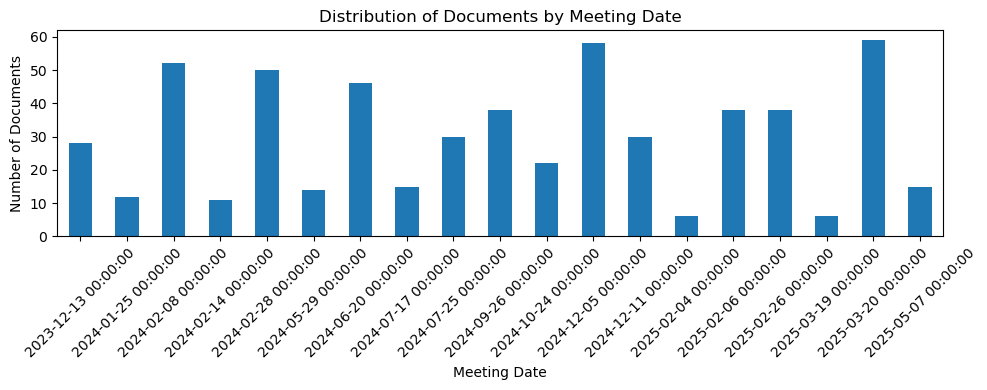

In [66]:
# Group by parsed meeting date
if df["meeting_date_parsed"].notna().any():
    plt.figure(figsize=(10, 4))
    df["meeting_date_parsed"].value_counts().sort_index().plot(kind="bar")
    plt.title("Distribution of Documents by Meeting Date")
    plt.xlabel("Meeting Date")
    plt.ylabel("Number of Documents")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid meeting_date found.")

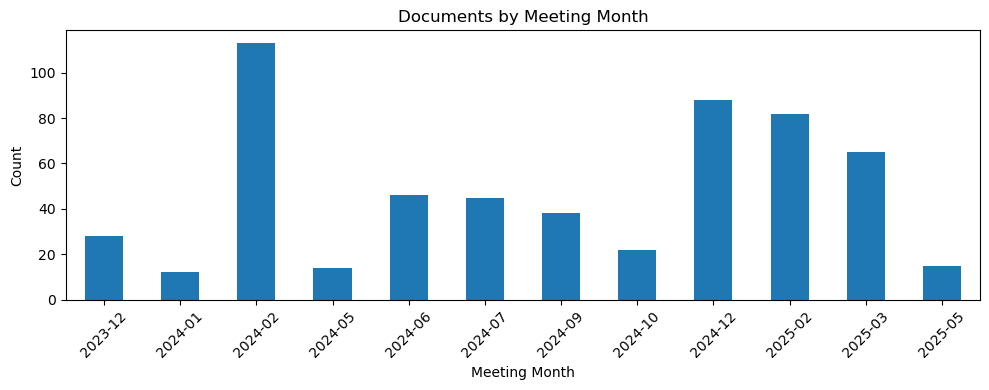

In [67]:
df["meeting_month"] = df["meeting_date_parsed"].dt.to_period("M")
df["meeting_month"].value_counts().sort_index().plot(kind="bar", figsize=(10, 4))
plt.title("Documents by Meeting Month")
plt.xlabel("Meeting Month")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Maidstone (encoded)

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse, parse_qs, unquote
import base64
import time
import json
import os
import re

# Load the CSV file
df = pd.read_csv("/Users/lgfolder/Downloads/maidstone.csv")

# Set for visited URLs to prevent duplicates
visited = set()

# Path to results file
results_path = "/Users/lgfolder/Downloads/pdf_results_maidstone.json"
if os.path.exists(results_path):
    with open(results_path, "r") as f:
        results_log = json.load(f)
else:
    results_log = []

# Helper: Check if a URL points to a PDF
def is_pdf(url):
    return url.lower().endswith(".pdf")

# Helper: Allow only ieListDocuments URLs with CId and MId (order-insensitive)
def is_allowed_ieListDocuments_url(url):
    if not isinstance(url, str):
        return False
    parsed = urlparse(url)
    if "ieListDocuments.aspx" not in parsed.path:
        return False
    query = parse_qs(parsed.query)
    return "CId" in query and "MId" in query

# Helper: Check if it's a valid starting page (meeting list or embedded list)
def is_valid_start_url(url):
    return isinstance(url, str) and url.startswith("http") and (
        "ieListMeetings.aspx" in url or "sq_content_src" in url)

# Decode Maidstone-style embedded links

def extract_embedded_url(url):
    parsed = urlparse(url)
    qs = parse_qs(parsed.query)
    sq_encoded = qs.get("sq_content_src", [None])[0]
    if not sq_encoded:
        return None
    try:
        decoded = base64.b64decode(sq_encoded[1:]).decode("utf-8")  # strip +
        real_url = parse_qs(decoded).get("url", [None])[0]
        return unquote(real_url) if real_url else None
    except Exception:
        return None

# Crawl PDFs from a specific meeting document page
def crawl_ieListDocuments_page(url, topic, source_url, depth=0, max_depth=2):
    pdf_links = set()
    if depth > max_depth or url in visited:
        return pdf_links

    if not is_allowed_ieListDocuments_url(url):
        return pdf_links

    visited.add(url)
    print(f"Crawling: {url} (depth={depth})")

    try:
        resp = requests.get(url, timeout=10)
        if resp.status_code != 200:
            return pdf_links
    except Exception as e:
        print(f"Failed to fetch {url}: {e}")
        return pdf_links

    soup = BeautifulSoup(resp.text, "html.parser")

    # Try to extract committee, date, and time from a heading
    committee = date = time_ = None
    heading_text = soup.find(string=re.compile(r" - .*\d{1,2}.*\d{4}"))
    if heading_text:
        match = re.match(r"(?P<committee>.+?) - .*?(?P<date>\d{1,2}(?:st|nd|rd|th)?\s+\w+,\s+\d{4})\s+(?P<time>\d{1,2}\.\d{2}\s*[ap]m)", heading_text.strip(), re.IGNORECASE)
        if match:
            committee = match.group("committee").strip()
            date = match.group("date").strip()
            time_ = match.group("time").strip()

    for a_tag in reversed(soup.find_all("a", href=True)):
        link = urljoin(url, a_tag['href'])
        if is_pdf(link):
            if link not in pdf_links:
                pdf_links.add(link)
                # Save immediately with metadata
                results_log.append({
                    "topic": topic,
                    "source_url": source_url,
                    "page_url": url,
                    "pdf_url": link,
                    "committee": committee,
                    "date": date,
                    "time": time_
                })
                with open(results_path, "w") as f:
                    json.dump(results_log, f, indent=2)
        time.sleep(0.25)

    return pdf_links

# Top-level crawler: start from meeting list, extract child meeting document pages
def crawl_from_meeting_list(start_url, topic):
    meeting_pdf_links = set()

    # Decode embedded URL if present
    embedded_url = extract_embedded_url(start_url)
    if embedded_url:
        print(f"Resolved embedded URL: {embedded_url}")
        start_url = embedded_url

    print(f"Scanning meeting list: {start_url}")
    try:
        resp = requests.get(start_url, timeout=10)
        if resp.status_code != 200:
            return meeting_pdf_links
    except Exception as e:
        print(f"Failed to fetch meeting list page {start_url}: {e}")
        return meeting_pdf_links

    soup = BeautifulSoup(resp.text, "html.parser")
    for a_tag in soup.find_all("a", href=True):
        link = urljoin(start_url, a_tag['href'])
        if is_allowed_ieListDocuments_url(link):
            meeting_pdf_links |= crawl_ieListDocuments_page(link, topic, start_url)
            time.sleep(0.25)

    return meeting_pdf_links

# Run crawler for each topic
pdf_map = {}
for _, row in df.iterrows():
    topic = row.get('topic')
    start_url = row.get('mother_url')

    if not is_valid_start_url(start_url):
        print(f"Skipping (not allowed): {start_url}")
        continue

    visited.clear()
    pdf_links = crawl_from_meeting_list(start_url, topic)
    pdf_map[topic] = list(pdf_links)
    print(f"Saved {len(pdf_links)} PDFs for topic: {topic}\n")

# The pdf_map now holds topic -> [list of PDF URLs]


## KCC Meeting metadata EDA

#### Loading the metadata and examining the scraping results

In [623]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

# Load JSONL file into a DataFrame
file_path = '../data/meetings/meetings_metadata.jsonl'
data = pd.read_json(file_path, lines=True)

# Show basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   web_meeting_code  2165 non-null   int64  
 1   meeting_title     2165 non-null   object 
 2   meeting_status    2165 non-null   object 
 3   committee_name    2163 non-null   object 
 4   meeting_date      2163 non-null   object 
 5   meeting_time      2163 non-null   float64
 6   agenda_items      2165 non-null   object 
 7   meeting_id        2165 non-null   object 
 8   scrape_timestamp  2165 non-null   object 
 9   error             0 non-null      float64
dtypes: float64(2), int64(1), object(7)
memory usage: 169.3+ KB


In [624]:
# Show the first few rows
#data.sample(1)

In [625]:
# Column names
print("Columns:", data.columns.tolist())

# Null values
print("\nMissing values per column:\n", data.isnull().sum())

# Unique values per column
print("\nUnique values per column:")
for col in data.columns:
    try:
        unique_count = data[col].nunique()
        print(f"{col}: {unique_count}")
    except TypeError:
        print(f"{col}: ❌ Cannot count unique values (unhashable type like list or dict)")
        
# If 'meeting_date' exists and is string, convert to datetime
if 'meeting_date' in data.columns:
    data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')
    print("\nDate range:", data['meeting_date'].min(), "to", data['meeting_date'].max())

Columns: ['web_meeting_code', 'meeting_title', 'meeting_status', 'committee_name', 'meeting_date', 'meeting_time', 'agenda_items', 'meeting_id', 'scrape_timestamp', 'error']

Missing values per column:
 web_meeting_code       0
meeting_title          0
meeting_status         0
committee_name         2
meeting_date           2
meeting_time           2
agenda_items           0
meeting_id             0
scrape_timestamp       0
error               2165
dtype: int64

Unique values per column:
web_meeting_code: 2162
meeting_title: 2162
meeting_status: 1
committee_name: 120
meeting_date: 1551
meeting_time: 5
agenda_items: ❌ Cannot count unique values (unhashable type like list or dict)
meeting_id: 2162
scrape_timestamp: 2165
error: 0

Date range: 2013-06-17 00:00:00 to 2026-07-23 00:00:00


Missing codes: 1838


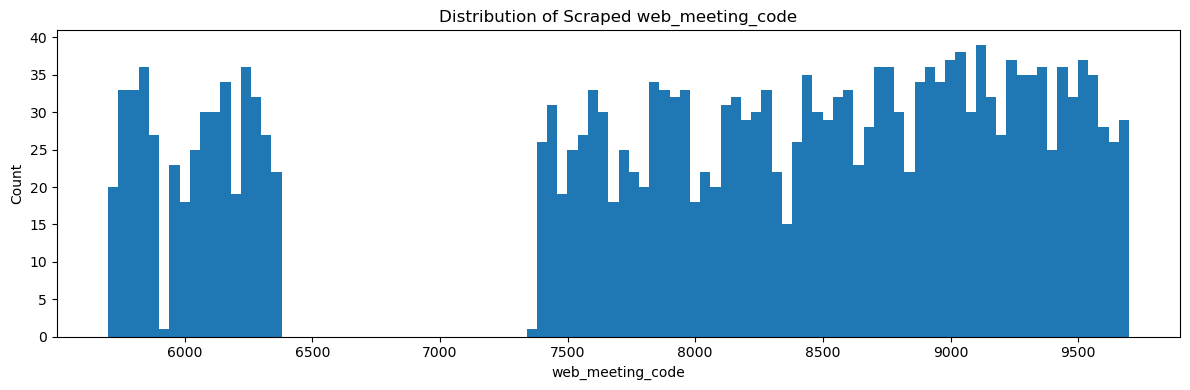

In [626]:
codes = data['web_meeting_code'].dropna().astype(int)
code_range = pd.Series(range(codes.min(), codes.max() + 1))

missing_codes = code_range[~code_range.isin(codes)]
print(f"Missing codes: {len(missing_codes)}")

plt.figure(figsize=(12, 4))
codes.plot(kind='hist', bins=100)
plt.title('Distribution of Scraped web_meeting_code')
plt.xlabel('web_meeting_code')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_84998/1028356808.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data['scrape_minute'] = data['scrape_timestamp'].dt.floor('T')
/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_84998/1028356808.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=data['scrape_minute'].min(),


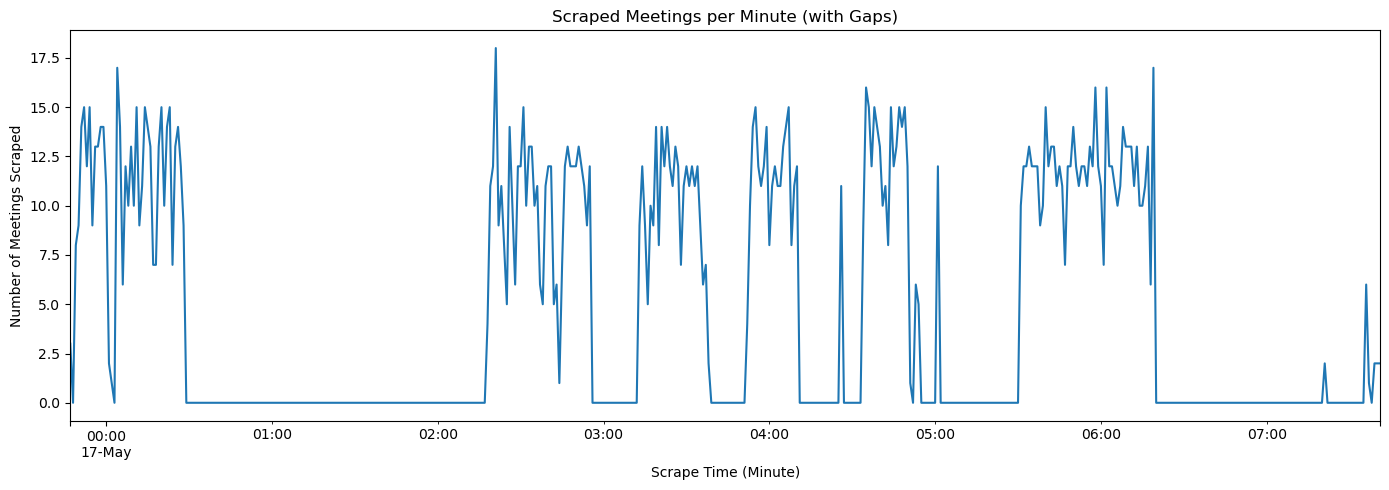

In [627]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to datetime
data['scrape_timestamp'] = pd.to_datetime(data['scrape_timestamp'], errors='coerce')

# Floor to minute
data['scrape_minute'] = data['scrape_timestamp'].dt.floor('T')

# Count scrapes per minute
scrape_counts = data['scrape_minute'].value_counts().sort_index()

# Create full range of minutes between first and last scrape
full_range = pd.date_range(start=data['scrape_minute'].min(),
                           end=data['scrape_minute'].max(),
                           freq='T')

# Reindex with full range, fill missing with 0
scrape_counts_full = scrape_counts.reindex(full_range, fill_value=0)

# Plot
plt.figure(figsize=(14, 5))
scrape_counts_full.plot()
plt.title('Scraped Meetings per Minute (with Gaps)')
plt.xlabel('Scrape Time (Minute)')
plt.ylabel('Number of Meetings Scraped')
plt.tight_layout()
plt.show()

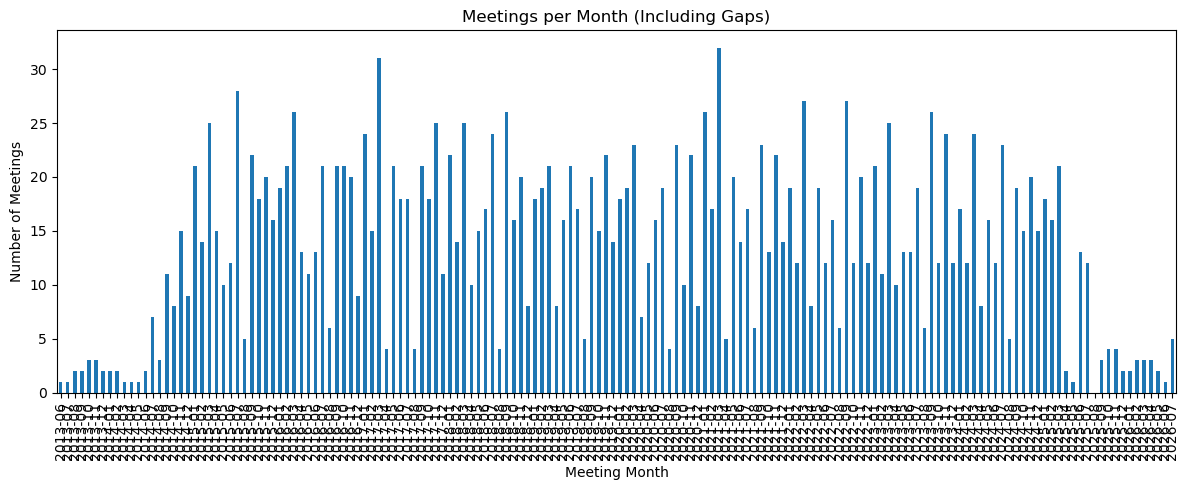

In [628]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert and extract meeting_month
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')
data['meeting_month'] = data['meeting_date'].dt.to_period('M')

# Count meetings per month
monthly_counts = data['meeting_month'].value_counts().sort_index()

# Create full continuous monthly index
full_index = pd.period_range(start=data['meeting_month'].min(),
                             end=data['meeting_month'].max(),
                             freq='M')

# Reindex to ensure gaps are shown with 0s
monthly_counts_full = monthly_counts.reindex(full_index, fill_value=0)

# Plot
plt.figure(figsize=(12, 5))
monthly_counts_full.plot(kind='bar')
plt.title('Meetings per Month (Including Gaps)')
plt.xlabel('Meeting Month')
plt.ylabel('Number of Meetings')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [629]:
missing_months = data[data['meeting_month'].isna()]
#missing_months.sample(2)

In [630]:
missing_month_count = data['meeting_month'].isna().sum()
print(f"Missing meeting_month values: {missing_month_count}")

Missing meeting_month values: 2


In [631]:
missing_dates = data[data['meeting_date'].isna()]
missing_dates[['meeting_id', 'meeting_title', 'committee_name', 'meeting_date']]

,meeting_id,meeting_title,committee_name,meeting_date
157,kent_cc_5959,"Dover North Neighbourhood Forum - Saturday, 22nd November, 2014 10.00 am",None,NaT
2164,kent_cc_5959,"Dover North Neighbourhood Forum - Saturday, 22nd November, 2014 10.00 am",None,NaT


In [632]:
# Define the fields you consider essential
essential_fields = ['meeting_title', 'meeting_status', 'committee_name', 'meeting_date', 'meeting_time', 'agenda_items']

# Filter rows where web_meeting_code exists AND any essential field is missing
incomplete_rows = data[
    data['web_meeting_code'].notna() & 
    data[essential_fields].isnull().any(axis=1)
]

print(len(incomplete_rows))
incomplete_rows

2


,web_meeting_code,meeting_title,meeting_status,committee_name,meeting_date,meeting_time,agenda_items,meeting_id,scrape_timestamp,error,scrape_minute,meeting_month
157,5959,"Dover North Neighbourhood Forum - Saturday, 22nd November, 2014 10.00 am",scheduled,None,NaT,NaN,[],kent_cc_5959,2025-05-17 00:04:13.249624,NaN,2025-05-17 00:04:00,NaT
2164,5959,"Dover North Neighbourhood Forum - Saturday, 22nd November, 2014 10.00 am",scheduled,None,NaT,NaN,[],kent_cc_5959,2025-05-17 07:41:47.248285,NaN,2025-05-17 07:41:00,NaT


In [633]:
rerun = incomplete_rows['web_meeting_code'].to_list()
rerun

[5959, 5959]

In [634]:
import pandas as pd

# Ensure codes are integers and sorted
codes = data['web_meeting_code'].dropna().astype(int)
all_codes = pd.Series(range(codes.min(), codes.max() + 1))

# Identify missing codes
missing_codes = all_codes[~all_codes.isin(codes)]

# Group into consecutive ranges
gap_ranges = []
if not missing_codes.empty:
    start = prev = missing_codes.iloc[0]
    for code in missing_codes[1:]:
        if code == prev + 1:
            prev = code
        else:
            gap_ranges.append((start, prev))
            start = prev = code
    gap_ranges.append((start, prev))  # add final group

# Create DataFrame of missing ranges
missing_df = pd.DataFrame(gap_ranges, columns=['missing_start', 'missing_end'])
missing_df['missing_count'] = missing_df['missing_end'] - missing_df['missing_start'] + 1

missing_df.sort_values(by=['missing_count'], ascending=False).head(15)

,missing_start,missing_end,missing_count
83,6378,7378,1001
21,5922,5954,33
20,5894,5920,27
171,8002,8023,22
56,6187,6206,20
214,8329,8347,19
140,7765,7776,12
131,7690,7701,12
283,8838,8847,10
362,9669,9678,10


In [635]:
# Ensure meeting_date is datetime
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')

# Create a Year-Month string column
data['year_month'] = data['meeting_date'].dt.to_period('M').astype(str)

# Group by year_month and get min, max, and count of web_meeting_code
grouped = data.groupby('year_month')['web_meeting_code'].agg(['min', 'max', 'count']).reset_index()

# Sort by month
grouped = grouped.sort_values('year_month')
grouped.tail(30)

,year_month,min,max,count
128,2024-02,9230,9435,12
129,2024-03,9209,9563,24
130,2024-04,9232,9555,8
131,2024-05,9210,9582,16
132,2024-06,9245,9589,12
133,2024-07,9211,9594,23
134,2024-08,9346,9602,5
135,2024-09,9437,9611,19
136,2024-10,9455,9626,15
137,2024-11,9448,9627,20


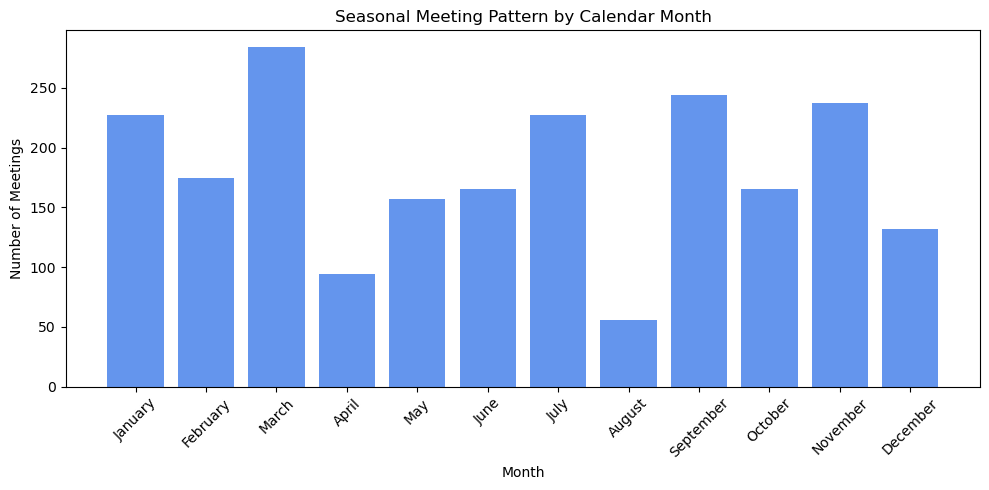

In [636]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime is parsed
data['meeting_date'] = pd.to_datetime(data['meeting_date'], errors='coerce')

# Extract numeric month (1–12) and month name
data['month'] = data['meeting_date'].dt.month
data['month_name'] = data['meeting_date'].dt.month_name()

# Group by month number and count meetings
monthly_pattern = data.groupby(['month', 'month_name']).size().reset_index(name='count')

# Sort by calendar order
monthly_pattern = monthly_pattern.sort_values('month')

# Plot
plt.figure(figsize=(10, 5))
plt.bar(monthly_pattern['month_name'], monthly_pattern['count'], color='cornflowerblue')
plt.title('Seasonal Meeting Pattern by Calendar Month')
plt.xlabel('Month')
plt.ylabel('Number of Meetings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [637]:
# Show a few non-empty agenda items
data['agenda_items'].dropna().iloc[0:3].tolist()

[[{'item_number': '1.',
   'item_title': 'Introduction/Webcast announcement',
   'item_text': 'Additional documents:',
   'pdf_urls': []},
  {'item_number': '2.',
   'item_title': 'Apologies and Substitutes',
   'item_text': 'Additional documents:',
   'pdf_urls': []},
  {'item_number': '3.',
   'item_title': 'Declarations of Interest by Members in items on the Agenda',
   'item_text': 'Additional documents:',
   'pdf_urls': []},
  {'item_number': '4.',
   'item_title': 'Minutes of the meeting held on 15 January 2025PDF 106 KB',
   'item_text': 'Additional documents:',
   'pdf_urls': ['https://democracy.kent.gov.uk/documents/s129468/Minutes of the meeting held on 15 January 2025.pdf']},
  {'item_number': '5.',
   'item_title': 'Risk Management: Chief Executive and Deputy Chief Executive DepartmentsPDF 111 KB',
   'item_text': 'Additional documents:',
   'pdf_urls': ['https://democracy.kent.gov.uk/documents/s129572/Risk Management Chief Executive and Deputy Chief Executive Departments.p

#### Cleanup of junk pdf scraping results

In [638]:
import re

def clean_item_title(title):
    if isinstance(title, str):
        return re.sub(r'\s*PDF\s*\d+(\.\d+)?\s*(KB|MB)', '', title, flags=re.IGNORECASE).strip()
    return title

def clean_agenda_items(items):
    if isinstance(items, list):
        for item in items:
            if isinstance(item, dict) and 'item_title' in item:
                item['item_title'] = clean_item_title(item['item_title'])
    return items

# Apply cleaning to the full DataFrame
data['agenda_items'] = data['agenda_items'].apply(clean_agenda_items)

#### Explore agendas

In [639]:
import pandas as pd

# Explode agenda_items so each item gets its own row
agenda_data = data.explode('agenda_items').dropna(subset=['agenda_items']).copy()

# Flatten the nested dictionaries into columns
agenda_flat = pd.json_normalize(agenda_data['agenda_items'])

# Add meeting context to each item
agenda_flat['meeting_id'] = agenda_data['meeting_id'].values
agenda_flat['committee_name'] = agenda_data['committee_name'].values
agenda_flat['meeting_date'] = agenda_data['meeting_date'].values

# Preview
agenda_flat.head()

,item_number,item_title,item_text,pdf_urls,meeting_id,committee_name,meeting_date
0,1.,Introduction/Webcast announcement,Additional documents:,[],kent_cc_9484,Policy and Resources Cabinet Committee,2025-03-05
1,2.,Apologies and Substitutes,Additional documents:,[],kent_cc_9484,Policy and Resources Cabinet Committee,2025-03-05
2,3.,Declarations of Interest by Members in items on the Agenda,Additional documents:,[],kent_cc_9484,Policy and Resources Cabinet Committee,2025-03-05
3,4.,Minutes of the meeting held on 15 January 2025,Additional documents:,[https://democracy.kent.gov.uk/documents/s129468/Minutes of the meeting held on 15 January 2025.pdf],kent_cc_9484,Policy and Resources Cabinet Committee,2025-03-05
4,5.,Risk Management: Chief Executive and Deputy Chief Executive Departments,Additional documents:,"[https://democracy.kent.gov.uk/documents/s129572/Risk Management Chief Executive and Deputy Chief Executive Departments.pdf, https://democracy.kent.gov.uk/documents/s129573/Appendix 1 - Chief Executive Department and Deputy Chief Executive Department led Corporate Risks - .pdf]",kent_cc_9484,Policy and Resources Cabinet Committee,2025-03-05


In [640]:
agenda_flat.groupby('meeting_id').size().sort_values(ascending=False)

meeting_id
kent_cc_9334    35
kent_cc_8558    30
kent_cc_7805    28
kent_cc_7804    28
kent_cc_8985    26
                ..
kent_cc_7473     1
kent_cc_8059     1
kent_cc_8540     1
kent_cc_9105     1
kent_cc_8293     1
Length: 1770, dtype: int64

In [641]:
agenda_flat['item_title'].str.lower().str.extract(r'(\w+)')[0].value_counts().head(20)

0
appeal          1480
minutes         1319
declarations     868
apologies        753
work             407
kent             402
verbal           335
update           260
motion           238
election         237
substitutes      222
membership       217
performance      184
a                184
b                177
c                174
d                173
date             157
proposal         132
24               123
Name: count, dtype: int64

In [642]:
# Flatten the list of all pdf URLs
all_pdfs = [url for sublist in agenda_flat['pdf_urls'] if isinstance(sublist, list) for url in sublist]

# Convert to Series for easier analysis
pdf_series = pd.Series(all_pdfs)

# Count total and duplicate entries
total_pdfs = pdf_series.size
unique_pdfs = pdf_series.nunique()
duplicate_pdfs = total_pdfs - unique_pdfs

print(f"Total PDF URLs: {total_pdfs}")
print(f"Unique PDF URLs: {unique_pdfs}")
print(f"Duplicate PDF URLs: {duplicate_pdfs}")

Total PDF URLs: 14923
Unique PDF URLs: 14908
Duplicate PDF URLs: 15


In [643]:
# Ensure all necessary columns exist
agenda_flat['num_pdfs'] = agenda_flat['pdf_urls'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Count meetings per committee (from original data)
meetings_per_committee = data.groupby('committee_name')['meeting_id'].nunique().rename('num_meetings')

# Count agenda items per committee
agenda_items_per_committee = agenda_flat.groupby('committee_name')['item_number'].count().rename('num_agenda_items')

# Count total PDFs per committee
pdfs_per_committee = agenda_flat.groupby('committee_name')['num_pdfs'].sum().rename('total_pdfs')

# Merge into one summary table
committee_summary = pd.concat([meetings_per_committee, agenda_items_per_committee, pdfs_per_committee], axis=1)

# Sort by number of meetings (or another metric if you prefer)
committee_summary = committee_summary.sort_values('num_meetings', ascending=False)

committee_summary.reset_index()
committee_summary.head(20)

,num_meetings,num_agenda_items,total_pdfs
committee_name,,,
Regulation Committee Appeal Panel (Transport),280,2318.0,1.0
Planning Applications Committee,122,630.0,629.0
Scrutiny Committee,108,414.0,609.0
Cabinet,107,564.0,671.0
Health Overview and Scrutiny Committee,80,634.0,642.0
Selection and Member Services Committee,77,202.0,243.0
Personnel Committee,74,378.0,220.0
Policy and Resources Cabinet Committee,67,750.0,883.0
"Growth, Economic Development and Communities Cabinet Committee",65,732.0,967.0


In [648]:
import re

# SELECT A COMMITTEE to veiw

#target_committee = "Policy and Resources Cabinet Committee"
target_committee = "Cabinet"
#target_committee = "County Council"
#target_committee = "Regulation Committee"
filtered_items = agenda_flat[
    agenda_flat['committee_name'].str.lower() == target_committee.lower()
].copy()

# Sort by meeting_date and item_number
filtered_items = filtered_items.sort_values(by=['meeting_date', 'item_number'])

# Ensure the number of PDFs column exists
agenda_flat['num_pdfs'] = agenda_flat['pdf_urls'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Normalize and filter by committee
filtered_items = agenda_flat[
    agenda_flat['committee_name'].str.lower() == target_committee.lower()
].copy()

# Sort and select
filtered_items = filtered_items.sort_values(by=['meeting_date', 'item_number'])

# Define phrases to exclude
exclusions = [
    "Apologies",
    "Declarations of Interest",
    "Date of next meeting",
    "EXEMPT ITEMS", 
    "Minutes"
]

# Filter out based on conditions
filtered_items_cleaned = filtered_items[
    ~filtered_items['item_title'].str.strip().str.lower().isin([e.lower() for e in exclusions]) &
    ~filtered_items['item_title'].str.strip().str.match(r'(?i)^minutes of the meeting') &
    ~filtered_items['item_title'].str.strip().str.match(r'(?i)^apologies') &
    ~filtered_items['item_title'].str.strip().str.match(r'(?i)^minutes') &
    ~filtered_items['item_title'].str.strip().str.match(r'(?i)^work programme') &
    ~filtered_items['item_title'].str.strip().str.match(r'(?i)^future meeting') &
    ~filtered_items['item_title'].str.strip().str.match(r'(?i)^introduction') &
    ~filtered_items['item_title'].str.strip().str.match(r'(?i)^Substitutes') &
    ~filtered_items['item_title'].str.strip().str.match(r'(?i)^declarations of ') 
]

# View result
filtered_items_cleaned[['meeting_date', 'item_number', 'item_title', 'num_pdfs']].tail(50)

,meeting_date,item_number,item_title,num_pdfs
13620,2024-01-04,25.,Cabinet Member Updates,0
13621,2024-01-04,26.,Revenue and Capital Budget Monitoring Report - October 2023-24,2
13622,2024-01-04,27.,"Quarterly Performance Report, Quarter 2, 2023/24",2
13623,2024-01-04,28.,Provisional Local Government Finance Settlement - Presentation,0
13624,2024-01-04,29.,Corporate Risk Register,2
13625,2024-01-04,30.,23/00091 - Kent and Medway Integrated Care Strategy,5
13629,2024-01-25,34.,Cabinet Member Updates,0
13630,2024-01-25,35.,Revenue and Capital Budget Monitoring Report - November 2023-2024,2
13631,2024-01-25,36.,"Revised Draft Revenue Budget 2024-25 and 2024-27 Medium Term Financial Plan, Draft Capital Programme 2024-34 and Treasury Management Strategy",6
13632,2024-01-25,37.,23/00105 - Commissioning Plan for Education Provision in Kent 2024-28,4


### Code to delete error rows in the meetings_metadata.json (if corrupted and have errors)

In [645]:
import pandas as pd
import shutil

# Define paths
source_path = '../data/meetings/meetings_metadata.jsonl'
backup_path = '../data/meetings/meetings_metadata_backup.jsonl'

# Step 1: Create backup copy
shutil.copy(source_path, backup_path)

# Step 2: Load data
data = pd.read_json(source_path, lines=True)

# Step 3: Filter out rows where 'error' is not NaN
cleaned_data = data[data['error'].isna()]

# Step 4: Overwrite original file with cleaned data
cleaned_data.to_json(source_path, orient='records', lines=True)

print(f"Backup saved to: {backup_path}")
print(f"Cleaned file saved to: {source_path}")

Backup saved to: ../data/meetings/meetings_metadata_backup.jsonl
Cleaned file saved to: ../data/meetings/meetings_metadata.jsonl
